In [1]:
#запуск spark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.master('local[6]').appName('twitter_analyze').config('spark.rpc.message.maxSize','512').getOrCreate()

In [2]:
#чистка от "мусора"
import nltk
from nltk.corpus import stopwords
import string

#nltk.download('stopwords')
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

def clear(mas):
    mas = [word.lower() for word in mas if word.lower() not in stop]
    return mas

In [3]:
#считывание данных и токенизация

import re
import json
import numpy as np

pattern = [
    r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)',
    r'(?:@[\w_]+)',
    r'http[s]?://[\S]+',
    r'(?:[0-9]+[.,]?[0-9]+)',
    r"(?:[\w][\w’'\-_]*[\w]*)"
]
comp = re.compile('('+'|'.join(pattern)+')', re.VERBOSE)

def tokenize(text):
    return comp.findall(text)

tweet_num = 1
    
def update(mas):
    global tweet_num
    newmas = []
    mas = clear(mas)
    for word in mas:
        newmas += [(word, tweet_num)]
    tweet_num += 1
    return newmas
    
    
def get_tweets(json_file):
    tweets = []
    with json_file:
        for line in json_file:
            tweets += update(tokenize(json.loads(line).get('full_text').replace('\n', ' ')))
    return tweets

mas = []
'''with open("/home/yury/datasets/data1.jsonl", encoding='utf-8') as json_file:
    mas += get_tweets(json_file)'''
with open("/home/yury/datasets/data2.jsonl", encoding='utf-8') as json_file:
    mas += get_tweets(json_file)

In [4]:
#Перевод в DataFrame
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
schema = StructType([ \
    StructField("word",StringType(),True), \
    StructField("tweet_id",IntegerType(),True), \
  ])
df = spark.createDataFrame(data=mas, schema=schema)

In [23]:
#Всего слов
df.count()

13984381

In [24]:
#Подсчет количества вхождений каждого слова
rdd2 = df.rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)
columns = ['word', 'count']
df2 = rdd2.toDF(columns)

In [25]:
#Топ 10 самых популярных слов
from pyspark.sql.functions import col, desc
df2.sort(desc("count")).show(20)

+-----------+------+
|       word| count|
+-----------+------+
|   covid-19|390634|
|      covid|133049|
|     corona|101155|
|        amp| 71386|
|     people| 69516|
|      virus| 65048|
|   #covid19| 58684|
|        new| 52255|
|        get| 51151|
|         us| 48426|
|   pandemic| 46581|
|coronavirus| 46530|
|      cases| 42953|
|       like| 41236|
|        one| 38297|
|     health| 37655|
|       help| 36999|
|       time| 35011|
|      trump| 32763|
|    vaccine| 32128|
+-----------+------+
only showing top 20 rows



In [40]:
#Топ 20 самых популярных хэштегов
df2.filter(df2['word'].substr(1, 1) == "#").sort(desc('count')).show(20)

+------------------+-----+
|              word|count|
+------------------+-----+
|          #covid19|58684|
|      #coronavirus|30278|
|         #covid_19|25701|
|          #moderna|23275|
|            #covid|18995|
|          #covaxin|14456|
|         #sputnikv|12182|
|         #covid-19|10657|
|          #vaccine|10442|
|           #corona| 8088|
|   #pfizerbiontech| 7566|
|           #pfizer| 6796|
|     #covidvaccine| 5848|
|         #pandemic| 4240|
|#oxfordastrazeneca| 3949|
|          #sinovac| 3830|
|        #covidー19| 3790|
|      #astrazeneca| 3711|
|         #stayhome| 3476|
|        #sinopharm| 3414|
+------------------+-----+
only showing top 20 rows



In [31]:
#Как часто встречаются названия популярных вакцин
myfilter = df2['word'].isin(['pfizer', '#pfizer', 'sputnikv', '#sputnikv', 'moderna', '#moderna', 'astrazeneca', '#astrazeneca', 'sinovac', '#sinovac'])
df2.filter(myfilter).sort(desc('count')).show()

+------------+-----+
|        word|count|
+------------+-----+
|    #moderna|23275|
|   #sputnikv|12182|
|     #pfizer| 6796|
|    #sinovac| 3830|
|#astrazeneca| 3711|
|     moderna| 2429|
|      pfizer| 1498|
| astrazeneca|  736|
|     sinovac|  475|
|    sputnikv|   79|
+------------+-----+



In [75]:
#Анализ семантики
from pyspark.sql.functions import col, desc, asc
import pandas

positive_words = {}
negative_words = {}
with open("/home/yury/datasets/positive-words.txt", 'r') as o:
    pos_words = o.read().splitlines()
for pos_word in pos_words:
    positive_words[pos_word] = 1
with open("/home/yury/datasets/negative-words.txt", 'r', encoding = "ISO-8859-1") as o:
    neg_words = o.read().splitlines()
for neg_word in neg_words:
    negative_words[neg_word] = 1

emotionpoints = [0 for i in range(tweet_num + 1)]
    
def prov(str, id):
    emotionpoints[id] += 1
    if positive_words.get(str) == 1:
        return 1
    elif negative_words.get(str) == 1:
        return -1
    else:
        return 0
    
rdd3 = df.rdd.map(lambda x: (x[1], prov(x[0], x[1]))).reduceByKey(lambda a, b: a + b)
columns = ['tweet_num', 'sentiment']
df3 = rdd3.toDF(columns)
rdd4 = df3.rdd.map(lambda x: (x[1], 1)).reduceByKey(lambda a, b: a + b)
columns = ['sentiment', 'count']
df4 = rdd4.toDF(columns)
z = df4.sort(asc('sentiment')).toPandas().values.tolist()

In [76]:
#from pyspark.sql.functions import col, desc
df4.sort(col('count').desc()).show()

+---------+------+
|sentiment| count|
+---------+------+
|        0|295292|
|       -1|158346|
|        1|143696|
|       -2| 68315|
|        2| 50767|
|       -3| 27626|
|        3| 17373|
|       -4| 11418|
|        4|  5847|
|       -5|  4727|
|        5|  1823|
|       -6|  1810|
|       -7|   746|
|        6|   529|
|       -8|   265|
|        7|   145|
|       -9|   100|
|      -10|    50|
|        8|    41|
|      -11|    14|
+---------+------+
only showing top 20 rows



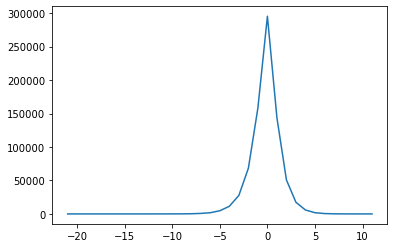

In [77]:
#График распределения настроений

x_axis = [0 for i in range(len(z))]
y_axis = [0 for i in range(len(z))]

for i in range(len(z)):
    x_axis[i]+= z[i][0]
    y_axis[i]+= z[i][1]

import matplotlib.pyplot as plt

plt.plot(x_axis, y_axis)
plt.show()



In [49]:
spark.stop()